In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Compute C2 analytically for a uniform spherical shell

In [180]:
R1=500;
R2=2000; # sphere inner/outer radii in Mpc
nbin = 30; # radial bins
mbin = 10; # mu bins
xi_0 = 100; # correlation function normalization
N_particles = 1e6;

In [181]:
Vol = np.pi*4./3.*(R2**3.-R1**3.)
n = float(N_particles)/Vol # no. density

In [182]:
mu_max = lambda r,s: (-r**2.-s**2.+R2**2.)/(2.*r*s)
mu_min = lambda r,s: (R1**2.-r**2.-s**2.)/(2.*r*s)

In [183]:
s_low = 50.+(200.-50.)/float(nbin)*(np.arange(nbin)) # lower boundary of radial bins
s_high = s_low+(200.-50.)/nbin
mu_low = np.arange(mbin)/float(mbin)
mu_high = mu_low + 1./mbin

In [184]:
from scipy.integrate import dblquad
def C2_integral(S1,S2,mu1,mu2):
    def X1_integrand(r,s,mu1,mu2):
        mumin = mu_min(r,s)
        muA=max([mu1,mumin])
        muB=max([mu2,mumin])
        if muA==muB:
            return 0.
        else:
            return r**2.*(muB-muA)*(xi_0+s**2.)
    X1_int = dblquad(X1_integrand,S1,S2,R1,lambda s: R1+s,args=(mu1,mu2))[0]
    
    def X2_integrand(r,s,mu1,mu2):
        return r**2.*(mu2-mu1)*(xi_0+s**2.)
    X2_int = dblquad(X2_integrand,S1,S2,lambda s: R1+s,lambda s: R2-s,args=(mu1,mu2))[0]
    
    def X3_integrand(r,s,mu1,mu2):
        mumax=mu_max(r,s)
        muA = min([mu1,mumax])
        muB = min([mu2,mumax])
        if muA==muB:
            return 0.
        else:
            return r**2.*(muB-muA)*(xi_0+s**2.)
    X3_int = dblquad(X3_integrand,S1,S2,lambda s: R2-s,R2,args=(mu1,mu2))[0]
    return 2.*8.*np.pi**2.*n**2.*(X1_int+X2_int+X3_int)

In [185]:
from scipy.integrate import dblquad
def C2_integral2(S1,S2,mu1,mu2):
    def tot_integrand(r,s,mu1,mu2):
        mumin = mu_min(r,s)
        mumax = mu_max(r,s)
        muA=min([mumax,max([mu1,mumin])])
        muB=min([mumax,max([mu2,mumin])])
        if muA==muB:
            return 0.
        else:
            return r**2.*(muB-muA)*(xi_0+s**2.)
    tot_int = dblquad(tot_integrand,S1,S2,lambda s: R1,R2,args=(mu1,mu2))[0]
    return 2.*8.*np.pi**2.*n**2.*tot_int

In [188]:
rr_true_file = '../weight_files/binned_pair_counts_n30_m10_j48.dat'
RR_true = np.loadtxt(rr_true_file)

In [189]:
C2_analyt=[];index=0
for i in range(len(s_low)):
    for j in range(len(mu_low)):
        # Keep same indexing as code:
        tmp_int=C2_integral2(s_low[i],s_high[i],mu_low[j],mu_high[j])
        tmp_int2=C2_integral2(s_low[i],s_high[i],-mu_high[j],-mu_low[j])
        C2_analyt.append((tmp_int+tmp_int2)/(RR_true[index]**2.))
        index+=1
C2_analyt=np.asarray(C2_analyt)

In [190]:
c2_est = np.loadtxt('../CovMatricesAll/c2_n30_m10_full.txt')

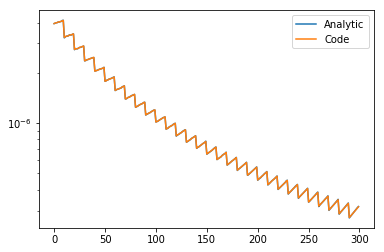

In [191]:
plt.plot(C2_analyt,label='Analytic')
plt.plot(c2_est,label='Code')
plt.yscale('log')
plt.legend();

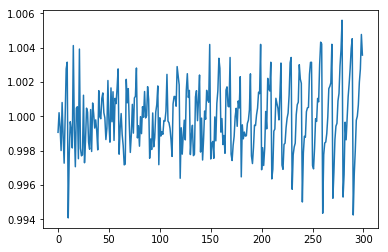

In [192]:
plt.plot(C2_analyt/c2_est,label='est')

## Compute C3 term:

In [17]:
from scipy.integrate import nquad

In [18]:
nquad()

<function scipy.integrate.quadpack.nquad>

In [26]:
def C3_integrand(mu_t,mu_s,t,s,r):
    prefactor = 64.*np.pi**3.
    a = (s**2.+t**2.+2.*t*s*mu_s*mu_t)
    b = 2.*t*s*np.sqrt(1.-mu_s**2.)*np.sqrt(1.-mu_t**2.)
    return prefactor/np.sqrt(a**2.+b**2.)*(r*s*t)**2.

In [20]:
s_low = 50.+(200.-50.)/float(nbin)*(np.arange(nbin)) # lower boundary of radial bins
s_high = s_low+(200.-50.)/nbin
mu_s_low = np.arange(mbin)/float(mbin)
mu_s_high = mu_low + 1./mbin
t_low = s_low; t_high = t_low;
mu_t_low = mu_s_low; mu_t_high=mu_s_high

In [29]:
i=0;j=0;k=0;l=0
def bounds_mu_s(t,s,r,mu1=ms1,mu2=ms2):
    if r<R1+s:
        mumin = mu_min(r,s)
        muA=max([mu1,mumin])
        muB=max([mu2,mumin])
    if r>R2-s:
        mumax=mu_max(r,s)
        muA = min([mu1,mumax])
        muB = min([mu2,mumax])
    else:
        muA=mu1;muB=mu2;
    return [muA,muB]

In [30]:
def bounds_mu_t(mu_s,t,s,r,mu1=mt1,mu2=mt2):
    if r<R1+t:
        mumin = mu_min(r,t)
        muA=max([mu1,mumin])
        muB=max([mu2,mumin])
    if r>R2-t:
        mumax=mu_max(r,t)
        muA = min([mu1,mumax])
        muB = min([mu2,mumax])
    else:
        muA=mu1;muB=mu2;
    return [muA,muB]

In [57]:
mt1=-1./6.;mt2=1./6.;ms1=-1./6.;ms2=1./6.;t1=50;t2=65.;s1=50.;s2=65.;
C3_integral=nquad(C3_integrand,[[mt1,mt2],[ms1,ms2],[t1,t2],[s1,s2],[R1,R2]],opts={'epsrel':0.01})
                  #[bounds_mu_t,bounds_mu_s,[t1,t2],[s1,s2],[R1,R2]],opts={'epsrel':0.1})

In [58]:
C3_integral/(RR_true[0]*RR_true[0])

array([1.52956274e+04, 1.69815578e-10])

In [59]:
c3_est = np.loadtxt('../CovMatricesAll/c3_n10_m6_full.txt')

In [64]:
c3_est[0,0]

7.126028e-07

## C3 for flat xi:

In [107]:
from scipy.integrate import tplquad
def C3_integral(S1,S2,T1,T2,mu1s,mu2s,mu1t,mu2t):
    def tot_integrand(t,s,r,mu1s,mu2s,mu1t,mu2t):
        mumins = mu_min(r,s)
        mumaxs = mu_max(r,s)
        mumint = mu_min(r,t)
        mumaxt = mu_max(r,t),
        muAt=min([mumaxt,max([mu1t,mumint])])
        muBt=min([mumaxt,max([mu2t,mumint])])
        muAs=min([mumaxs,max([mu1s,mumins])])
        muBs=min([mumaxs,max([mu2s,mumins])])
        if muAs==muBs:
            return 0.
        elif muBt==muAt:
            return 0.
        else:
            return s**2.*t**2.*r**2.*(muBs-muAs)*(muBt-muAt)
    tot_int = tplquad(tot_integrand,R1,R2,S1,S2,T1,T2,args=(mu1s,mu2s,mu1t,mu2t),epsrel=1e-2)[0]
    return 64.*np.pi**3.*n**3.*tot_int

#### Compute only diagonal elements here:

In [108]:
C3_diag_analyt=[];index=0
for i in range(len(s_low)):
    for j in range(len(mu_low)):
        # Keep same indexing as code:
        tmp_int=C3_integral(s_low[i],s_high[i],s_low[i],s_high[i],mu_low[j],mu_high[j],mu_low[j],mu_high[j])
        tmp_int2=C3_integral(s_low[i],s_high[i],s_low[i],s_high[i],-mu_high[j],-mu_low[j],mu_low[j],mu_high[j])
        tmp_int3=C3_integral(s_low[i],s_high[i],s_low[i],s_high[i],mu_low[j],mu_high[j],-mu_high[j],-mu_low[j])
        tmp_int4=C3_integral(s_low[i],s_high[i],s_low[i],s_high[i],-mu_high[j],-mu_low[j],-mu_high[j],-mu_low[j])
        C3_diag_analyt.append((tmp_int+tmp_int2+tmp_int3+tmp_int4)/(RR_true[index]**2.))
        index+=1
        print("index %d of %d done" %(index,len(s_low)*len(mu_low)))
C3_diag_analyt=np.asarray(C3_diag_analyt)

index 1 of 60 done
index 2 of 60 done
index 3 of 60 done
index 4 of 60 done
index 5 of 60 done
index 6 of 60 done
index 7 of 60 done
index 8 of 60 done
index 9 of 60 done
index 10 of 60 done
index 11 of 60 done
index 12 of 60 done
index 13 of 60 done
index 14 of 60 done
index 15 of 60 done
index 16 of 60 done
index 17 of 60 done
index 18 of 60 done
index 19 of 60 done
index 20 of 60 done
index 21 of 60 done
index 22 of 60 done
index 23 of 60 done
index 24 of 60 done
index 25 of 60 done
index 26 of 60 done
index 27 of 60 done
index 28 of 60 done
index 29 of 60 done
index 30 of 60 done
index 31 of 60 done
index 32 of 60 done
index 33 of 60 done
index 34 of 60 done
index 35 of 60 done
index 36 of 60 done
index 37 of 60 done
index 38 of 60 done
index 39 of 60 done
index 40 of 60 done
index 41 of 60 done
index 42 of 60 done
index 43 of 60 done
index 44 of 60 done
index 45 of 60 done
index 46 of 60 done
index 47 of 60 done
index 48 of 60 done
index 49 of 60 done
index 50 of 60 done
index 51 

In [171]:
from scipy.integrate import dblquad
def C2_integral3(S1,S2,mu1,mu2):
    def tot_integrand(r,s,mu1,mu2):
        mumin = mu_min(r,s)
        mumax = mu_max(r,s)
        muA=min([mumax,max([mu1,mumin])])
        muB=min([mumax,max([mu2,mumin])])
        if muA==muB:
            return 0.
        else:
            return r**2.*(muB-muA)*2.*s**2.
    tot_int = dblquad(tot_integrand,S1,S2,lambda s: R1,R2,args=(mu1,mu2))[0]
    return 2.*8.*np.pi**2.*n**2.*tot_int

In [172]:
C2_analyt=[];index=0
for i in range(len(s_low)):
    for j in range(len(mu_low)):
        # Keep same indexing as code:
        tmp_int=C2_integral3(s_low[i],s_high[i],mu_low[j],mu_high[j])
        tmp_int2=C2_integral3(s_low[i],s_high[i],-mu_high[j],-mu_low[j])
        C2_analyt.append((tmp_int+tmp_int2)/(RR_true[index]**2.))
        index+=1
C2_analyt=np.asarray(C2_analyt)

In [177]:
c2_est = np.loadtxt('../CovMatricesAll/c2_n10_m6_full.txt')
c3_est = np.loadtxt('../CovMatricesAll/c3_n10_m6_full.txt')

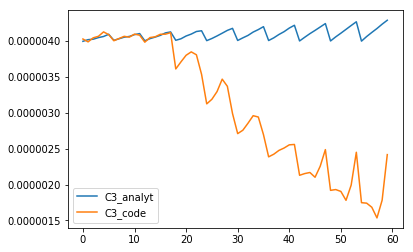

In [179]:
#plt.plot(C2_analyt,label='C2_analyt')
plt.plot(C3_diag_analyt,label='C3_analyt')
#plt.plot(c2_est,label='C2_code')
plt.plot(np.diag(c3_est),label='C3_code')
plt.legend()